## Building a Deep Learning Based Movie Recommendation System based on Collaborative Filtering using Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras import backend
from keras.models import Model
from keras.layers import Input, Concatenate, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Import Dependencies

In [2]:
ratings = pd.read_csv("ml-latest-small/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Data preprocessing

In [4]:
user_ids = ratings["userId"].unique().tolist()

user_le = LabelEncoder()
ratings['user'] = user_le.fit_transform(ratings['userId'].values)

le_user_mapping = dict(zip(user_le.classes_, user_le.transform(user_le.classes_)))

n_users = ratings['user'].nunique()

movie_ids = ratings["movieId"].unique().tolist()

movie_le = LabelEncoder()
ratings['movie'] = movie_le.fit_transform(ratings['movieId'].values)

le_movie_mapping = dict(zip(movie_le.classes_, movie_le.transform(movie_le.classes_)))
movie_mapping_le = dict(zip(le_movie_mapping.values(),le_movie_mapping.keys()))

n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)

min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

In [5]:
ratings.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46


### Prepare training/test data

In [6]:
X = ratings[['user', 'movie']].values
# Normalize the targets between 0 and 1.
y = ratings['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 2), (10084, 2), (90752,), (10084,))

### Build the model

In [7]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [8]:
embedding_size = 50

class Recommender(Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(Recommender, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=l2(1e-6),
        )

        self.movie_embedding = Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=l2(1e-6),
        )

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        
        x = Concatenate()([user_vector, movie_vector])
        x = Dropout(0.05)(x)
        x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
        x = Dropout(0.5)(x)
        x = Dense(1, kernel_initializer='he_normal')(x)
        
        return x

In [9]:
model = Recommender(n_users, n_movies, embedding_size)
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=[rmse])

### Train the model

In [10]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(X_test, y_test),
)

Train on 90752 samples, validate on 10084 samples
Epoch 1/20
90752/90752 [==============================] - 13s 148us/step - loss: 0.1263 - rmse: 0.2799 - val_loss: 0.0444 - val_rmse: 0.1638
Epoch 2/20
90752/90752 [==============================] - 18s 194us/step - loss: 0.0534 - rmse: 0.1815 - val_loss: 0.0412 - val_rmse: 0.1557
Epoch 3/20
90752/90752 [==============================] - 14s 153us/step - loss: 0.0501 - rmse: 0.1742 - val_loss: 0.0413 - val_rmse: 0.1551
Epoch 4/20
90752/90752 [==============================] - 12s 131us/step - loss: 0.0491 - rmse: 0.1715 - val_loss: 0.0418 - val_rmse: 0.1553
Epoch 5/20
90752/90752 [==============================] - 13s 147us/step - loss: 0.0487 - rmse: 0.1704 - val_loss: 0.0421 - val_rmse: 0.1559
Epoch 6/20
90752/90752 [==============================] - 23s 250us/step - loss: 0.0480 - rmse: 0.1686 - val_loss: 0.0424 - val_rmse: 0.1560
Epoch 7/20
90752/90752 [==============================] - 26s 282us/step - loss: 0.0476 - rmse: 0.1684 -

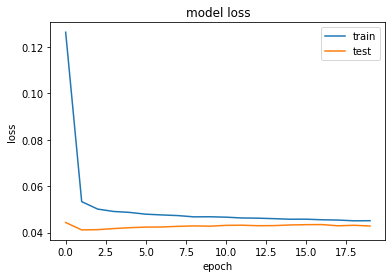

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

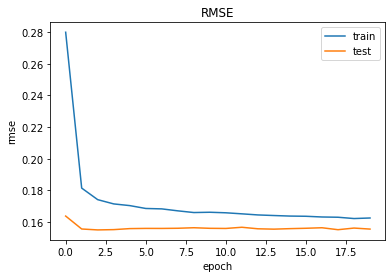

In [12]:
# plot training curve for rmse
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('RMSE')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Show the top 10 movie recommendations for a user

In [13]:
# Get a user for recommendations.
user_id = ratings['userId'].sample(1).iloc[0]

movies_watched_by_user = ratings[ratings['userId'] == user_id]
movies_not_watched_by_user = list(set(movie_ids).difference(set(movies_watched_by_user.movieId.values)))
movies_not_watched_by_user = [[le_movie_mapping.get(x)] for x in movies_not_watched_by_user]

user_encoded = le_user_mapping.get(user_id)
combined_user_movie_array = np.hstack(
    ([[user_encoded]] * len(movies_not_watched_by_user), movies_not_watched_by_user)
)

movie_ratings = model.predict(combined_user_movie_array).flatten()
top_ratings_indices = np.flipud(movie_ratings.argsort()[-10:])

recommended_movie_ids = [
    movie_mapping_le.get(movies_not_watched_by_user[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("===" * 13)
print("Movies with high ratings from user")
print("---" * 13)

top_movie_ids_rated_by_user = movies_watched_by_user.sort_values(by="rating", ascending=False).movieId.values[:10]
top_movies_rated_by_user = movies[movies["movieId"].isin(top_movie_ids_rated_by_user)].title.values

for i in range(len(top_movies_rated_by_user)): 
    print (top_movies_rated_by_user[i])
    
print("###" * 13)
print("Top 10 movie recommendations")
print("---" * 13)
recommended_movies = movies[movies["movieId"].isin(recommended_movie_ids)].title.values

for j in range(len(recommended_movies)): 
    print (recommended_movies[j])

Showing recommendations for user: 312
Movies with high ratings from user
---------------------------------------
Schindler's List (1993)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
English Patient, The (1996)
Star Wars: Episode V - The Empire Strikes Back (1980)
Chinatown (1974)
Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out of Balance) (1983)
Close Encounters of the Third Kind (1977)
Empire of the Sun (1987)
Evil Dead, The (1981)
Suspiria (1977)
#######################################
Top 10 movie recommendations
---------------------------------------
World of Apu, The (Apur Sansar) (1959)
Meet Me in St. Louis (1944)
Secrets & Lies (1996)
Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto) (1975)
Woman in the Dunes (Suna no onna) (1964)
Jonah Who Will Be 25 in the Year 2000 (Jonas qui aura 25 ans en l'an 2000) (1976)
Blood Simple (1984)
Wild Tales (2014)
Captain Fantastic (2016)
Band of Brothers (2001)
